In [1]:
import os
import cv2

from dataset_process import dataset_to_df, search_df
from engine import train_fn , eval_fn

import numpy as np
import pandas as pd

from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F

# The cross-entropy loss penalizes the model more when it is more confident in the incorrect class
from torch.nn import CrossEntropyLoss

# Adam is an optimization algorithm that can be used instead of the classical SGD procedure
# to update network weights iterative based in training data.
from torch.optim import Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
from torchvision import transforms
from torchvision.io import read_image

import albumentations as alb

from torchinfo import summary

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

from typing import Optional, Tuple
import timm
import wandb
import time
from utils import progress_bar
import csv


In [2]:
print(f"torch version: {torch.__version__}")
print(f"GPU Card: {torch.cuda.get_device_name(0)}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Torch is using device:', device)
torch.cuda.get_device_name(device)

NUM_WORKERS = os.cpu_count()
print("CPU Count:", NUM_WORKERS)

torch version: 2.2.2+cu121
GPU Card: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Torch is using device: cuda:0
CPU Count: 20


In [3]:
usewandb = False
resume=False

In [4]:
img_size = 32  # 384 #for timm vit
patch_size = 8
trans_img_resize = 32
embed_size=3*patch_size**2
mlp_dim= 512
train_batch_size = 512
valid_batch_size = 100
num_classes=10
encoder_depth=6
attention_heads=12

print(f'Flattened dimension size(of a patch): {3*patch_size**2}')
print(f'Embedding Size: {embed_size}')
print(f'Output MLP size: {mlp_dim}')

Flattened dimension size(of a patch): 192
Embedding Size: 192
Output MLP size: 512


In [5]:
# https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.model(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, emb_dropout = 0., dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [6]:
norm_mean = [0.4913997551666284, 0.48215855929893703, 0.4465309133731618]
norm_std = [0.24703225141799082, 0.24348516474564, 0.26158783926049628]

In [7]:
transform_train = transforms.Compose([
    transforms.RandAugment(2, 14),
    transforms.RandomCrop(32, padding=4),
    transforms.Resize(trans_img_resize),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

transform_valid = transforms.Compose([
    transforms.Resize(trans_img_resize),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

In [8]:
# Prepare dataset
train_set = torchvision.datasets.CIFAR10(root='../../data/CIFAR10', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=NUM_WORKERS )

valid_set = torchvision.datasets.CIFAR10(root='../../data/CIFAR10', train=False, download=True, transform=transform_valid)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=valid_batch_size, shuffle=False, num_workers=NUM_WORKERS )

Files already downloaded and verified
Files already downloaded and verified


In [9]:
sample_img_batch,label = next(iter(train_loader))

print(f"Batch of Images Shape: {sample_img_batch.size()}")
print(f"Batch of Images Shape: {label.size()}")
print(label)

Batch of Images Shape: torch.Size([512, 3, 32, 32])
Batch of Images Shape: torch.Size([512])
tensor([8, 0, 7, 3, 4, 5, 8, 2, 0, 1, 4, 9, 6, 8, 9, 9, 1, 7, 7, 9, 2, 3, 7, 2,
        1, 1, 9, 3, 8, 2, 0, 4, 1, 3, 9, 2, 5, 8, 4, 2, 8, 0, 5, 3, 9, 1, 1, 8,
        0, 0, 5, 8, 5, 5, 4, 4, 6, 3, 3, 3, 0, 5, 3, 1, 5, 5, 5, 0, 8, 6, 0, 5,
        8, 8, 5, 8, 7, 4, 1, 0, 0, 1, 9, 7, 6, 9, 8, 4, 8, 9, 4, 2, 9, 1, 9, 3,
        7, 4, 0, 7, 9, 5, 0, 9, 8, 3, 4, 1, 9, 2, 2, 5, 1, 0, 7, 3, 8, 9, 8, 0,
        2, 9, 9, 4, 1, 2, 2, 3, 3, 4, 2, 8, 1, 5, 0, 1, 5, 9, 4, 5, 4, 6, 5, 5,
        9, 6, 7, 6, 5, 4, 3, 5, 4, 8, 3, 2, 8, 0, 0, 6, 5, 0, 9, 8, 4, 3, 2, 4,
        4, 8, 7, 6, 2, 6, 5, 5, 0, 0, 8, 9, 1, 7, 2, 3, 9, 0, 5, 0, 7, 9, 0, 5,
        5, 6, 7, 2, 8, 8, 7, 4, 1, 2, 3, 5, 6, 3, 9, 9, 7, 3, 7, 6, 8, 4, 5, 1,
        1, 9, 7, 1, 0, 3, 0, 4, 7, 2, 9, 7, 9, 5, 4, 5, 9, 1, 3, 4, 4, 7, 7, 9,
        3, 0, 7, 7, 3, 7, 6, 5, 5, 5, 3, 3, 9, 4, 5, 4, 0, 0, 8, 5, 8, 2, 8, 6,
        9, 1, 7, 8, 0, 7, 7

In [10]:
class SliceImage:
    def __init__(self, slice_width):
        self.slice_width = slice_width

    def slice(self, img):
        # c: color channels

        # h: desired slice height (pixels)
        # w: desired slice width (pixels)

        # row: No. of vertical slices
        # col: No. of horizontal slices

        # b: Batch of Images

        sliced_Img = rearrange(
            img, 'c (row h) (col w) -> row col c h w', h=self.slice_width, w=self.slice_width)

        return sliced_Img

    def __call__(self, img):
        sliced_img = self.slice(img)
        sliced_flattened_img = rearrange(
            sliced_img, 'row col c h w -> (row col) (c h w)')

        return sliced_flattened_img

    plt.show()

In [11]:
def img_data(train_loader, index):

    img, label = train_loader.dataset[index]

    channels, img_H, img_W = img.size()
    
    batch = train_loader.batch_size

    return img, label, channels, img_H, batch

In [12]:
def img_plot(img, slice_width):
    slice = SliceImage(slice_width)
    sliced_img = slice.slice(img)
    print("Sliced Image Shape: ", sliced_img.shape)

    fig = plt.figure(layout="constrained", figsize=(8, 4))
    subfigs = fig.subfigures(3, 1, height_ratios=[1., 1.5, 1.], hspace=0.05, squeeze='True')

    axs0 = subfigs[0].subplots(1, 1)
    img_a = rearrange(img, "c h w -> h w c").numpy()
    
    axs0.imshow(img_a)
    axs0.axis('off')
    # subfigs[0].suptitle('Input Image', fontsize=10)

    grid1 = ImageGrid(subfigs[1], 111, nrows_ncols=(sliced_img.size(0), sliced_img.size(1)), axes_pad=0.03)

    for i, ax in enumerate(grid1):
        i_b4 = str(np.base_repr(i, sliced_img.size(0))).zfill(2)
        row = int(i_b4[0])
        column = int(i_b4[1])
        patch = rearrange(sliced_img[row][column], "c h w -> h w c").numpy()
        
        ax.imshow(patch)
        ax.axis('off')
    # subfigs[1].suptitle('Slices', fontsize=10)

    grid2 = ImageGrid(subfigs[2], 111, nrows_ncols=(1, sliced_img.size(0)*sliced_img.size(1)), axes_pad=0.03)

    for i, ax in enumerate(grid2):
        i_b4 = str(np.base_repr(i, sliced_img.size(0))).zfill(2)
        row = int(i_b4[0])
        column = int(i_b4[1])
        patch = sliced_img[row][column].permute(1, 2, 0).numpy()
        
        ax.imshow(patch)
        ax.axis('off')
    # subfigs[2].suptitle('Position', fontsize=10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input Image Shape: torch.Size([3, 32, 32])
Sliced Image Shape:  torch.Size([4, 4, 3, 8, 8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i


slice_embed 192


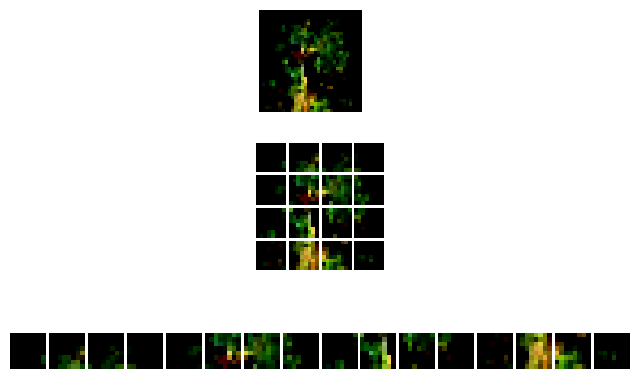

In [13]:
sample_img, _ = train_set[10]
sample_img_tr, sample_img_label, ch, img_size, batch_size = img_data(train_loader, 2)
print(f"Input Image Shape: {sample_img_tr.size()}")
img_plot(sample_img, patch_size)

print("")

slice_embed = embed_size
print("slice_embed", slice_embed)

In [14]:
n_epochs = 200         # Number of epochs
base_lr = 10e-3         # Base LR
weight_decay = 0.03     # Weight decay for ViT-Base (on ImageNet-21k)

In [15]:
model = ViT(
    image_size=img_size,
    patch_size=patch_size,
    num_classes=num_classes,
    dim=slice_embed,
    depth=encoder_depth,
    heads=attention_heads,
    mlp_dim=mlp_dim,
    emb_dropout=0.1,
    dropout=0.1
)


# model = timm.create_model("vit_base_patch16_384", pretrained=True)
# model.head = nn.Linear(model.head.in_features, 10)

In [16]:
vit_output = model(sample_img_batch)

print("Input Shape: ", sample_img_batch.size())
print("Output Shape: ", vit_output.size())

summary(model=model,
        input_size=sample_img_batch.size(),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Input Shape:  torch.Size([512, 3, 32, 32])
Output Shape:  torch.Size([512, 10])


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                          [512, 3, 32, 32]     [512, 10]            3,456                True
├─Sequential (to_patch_embedding)                  [512, 3, 32, 32]     [512, 16, 192]       --                   True
│    └─Rearrange (0)                               [512, 3, 32, 32]     [512, 16, 192]       --                   --
│    └─Linear (1)                                  [512, 16, 192]       [512, 16, 192]       37,056               True
├─Dropout (dropout)                                [512, 17, 192]       [512, 17, 192]       --                   --
├─Transformer (transformer)                        [512, 17, 192]       [512, 17, 192]       --                   True
│    └─ModuleList (layers)                         --                   --                   --                   True
│    │    └─ModuleList (0)                     

In [17]:
model_state_path="../weights/vit10/checkpoint"

In [18]:
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=base_lr)
# optimizer = optim.SGD(model.parameters(), lr=base_lr)  
    
# use cosine scheduling
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)

In [19]:

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    # assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('../weights/vit10/checkpoint/vit-ckpt.t7')
    model.load_state_dict(checkpoint['model'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

In [20]:
def train(epoch,epochs):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    loop = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (inputs, targets) in loop:
        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Zero gradients for every batch
        optimizer.zero_grad()
        # Backward path (Gradient)
        loss.backward()
        # Optimizer(Adam) Step
        optimizer.step()


        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        avg_tr_loss=train_loss/(batch_idx+1)
        avg_tr_accuracy=100.*correct/total

        loop.set_description(f"Training--Epoch [{epoch+1}/{epochs}]")
        loop.set_postfix(loss=avg_tr_loss, acc=avg_tr_accuracy)

    return avg_tr_loss

def validate(epoch,epochs,model_state_path):
    global best_acc
    model.eval()
    valid_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():

        loop = tqdm(enumerate(valid_loader), total=len(valid_loader))
        for batch_idx, (inputs, targets) in loop:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            avg_valid_loss=valid_loss/(batch_idx+1)
            avg_valid_accuracy=100.*correct/total
            
            loop.set_description(f"Validation--Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=avg_valid_loss, acc=avg_valid_accuracy)

            # progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            #              % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    if avg_valid_accuracy > best_acc:
        print('Saving..')
        state = {"model": model.state_dict(),
                 "optimizer": optimizer.state_dict()}

        torch.save(state,model_state_path+f'vit_{patch_size}_epoch_{epoch}')
        best_acc = avg_valid_accuracy


    return valid_loss, avg_valid_accuracy

In [21]:
# # Training
# scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


# def train(epoch):
#     print('\nEpoch: %d' % epoch)
#     model.train()
#     train_loss = 0
#     correct = 0
#     total = 0
#     for batch_idx, (inputs, targets) in enumerate(trainloader):
#         inputs, targets = inputs.to(device), targets.to(device)
#         # Train with amp
#         with torch.cuda.amp.autocast(enabled=use_amp):
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.update()
#         optimizer.zero_grad()

#         train_loss += loss.item()
#         _, predicted = outputs.max(1)
#         total += targets.size(0)
#         correct += predicted.eq(targets).sum().item()

#         progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
#                      % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
#     return train_loss/(batch_idx+1)

# # Validation


# def test(epoch):
#     global best_acc
#     model.eval()
#     test_loss = 0
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for batch_idx, (inputs, targets) in enumerate(testloader):
#             inputs, targets = inputs.to(device), targets.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)

#             test_loss += loss.item()
#             _, predicted = outputs.max(1)
#             total += targets.size(0)
#             correct += predicted.eq(targets).sum().item()

#             progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
#                          % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

#     # Save checkpoint.
#     acc = 100.*correct/total
#     if acc > best_acc:
#         print('Saving..')
#         state = {"model": model.state_dict(),
#                  "optimizer": optimizer.state_dict(),
#                  "scaler": scaler.state_dict()}
#         # if not os.path.isdir('checkpoint'):
#         #     os.mkdir('checkpoint')
#         torch.save(state,f'../weights/vit10/checkpoint/vit-{patch_size}-ckpt.t7')
#         best_acc = acc

#     os.makedirs("log", exist_ok=True)
    # content = time.ctime() + ' ' + \
    #     f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, val loss: {test_loss:.5f}, acc: {(acc):.5f}'
    # print(content)
    # with open(f'log/log_vit_patch{patch_size}.txt', 'a') as appender:
    #     appender.write(content + "\n")
    # return test_loss, acc

In [22]:
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

list_loss = []
list_acc = []

if usewandb:
    watermark = f"vit_lr{base_lr}"
    wandb.init(project="cifar10-challange",name=watermark)
    wandb.watch(model)

model.cuda()
for epoch in range(start_epoch, n_epochs):
    start = time.time()
    tr_loss = train(epoch,n_epochs)
    val_loss, acc = validate(epoch,n_epochs,model_state_path)
    
    scheduler.step() # step cosine scheduling
    
    list_loss.append(val_loss)
    list_acc.append(acc)
    
    # Log training..
    if usewandb:
        wandb.log({'epoch': epoch, 'train_loss': trainloss, 'val_loss': val_loss, "val_acc": acc, "lr": optimizer.param_groups[0]["lr"],
        "epoch_time": time.time()-start})

    # Write out csv..
    with open(f'../weights/vit10/log_vit_patch{patch_size}.csv', 'w') as f:
        writer = csv.writer(f, lineterminator='\n')
        writer.writerow(list_loss) 
        writer.writerow(list_acc) 
    print(list_loss)

# writeout wandb
if usewandb:
    wandb.save(f"../weights/vit10/wandb/wandb_vit.h5")



Epoch: 0


KeyboardInterrupt: 